In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [2]:
root_path = "perlmutter"

In [3]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [4]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [9]:
def create_df(path):
    data = []
    for file in Path(f"{path}/data").iterdir():
        if m := name_re.search(file.name):
            with open(file, "r") as input:
                if t_m := time_re.search(input.read()):
                    duration = t_m.group(1)
                    data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                                 "type": m.group(5), "nodes": m.group(6), "time": duration})
    df = pd.DataFrame(data)
    return df.drop(columns=["scaling", "type"]).astype({"dim": int, "n": int, "nodes": int, "time": float})

In [10]:
def pivot(df):
    piv = df.pivot(index="nodes", columns=["comm_pattern", "dim", "n"], values="time")
    return piv[piv.columns.sort_values()]

In [11]:
df_gpu_aware = create_df(root_path)
df_gpu_aware = pivot(df_gpu_aware)
df_gpu_aware

comm_pattern neighborhood                                                    \
dim                     2                                                 3   
n                 100       1000      10000     100000    1000000   100       
nodes                                                                         
1                0.000075  0.000075  0.000070  0.000067  0.000310  0.000075   
2                0.000113  0.000114  0.000108  0.000102  0.000339  0.000150   
4                0.000168  0.000169  0.000146  0.000138  0.000361  0.000223   
8                0.000169  0.000169  0.000146  0.000137  0.000350  0.000333   
16               0.000171  0.000169  0.000149  0.000142  0.000351  0.000494   
32               0.000185  0.000189  0.000149  0.000140  0.000359  0.000500   
64               0.000177  0.000179  0.000149  0.000130  0.000355  0.000524   
128              0.000172  0.000176  0.000149  0.000146  0.000359       NaN   

comm_pattern                                           stencil            \
dim                                                          2             
n              1000      10000     100000    1000000   100       1000      
nodes                                                                      
1             0.000062  0.000061  0.000110  0.000567  0.000085  0.000084   
2             0.000139  0.000119  0.000150  0.000683  0.000125  0.000125   
4             0.000195  0.000190  0.000203  0.000693  0.000179  0.000179   
8             0.000291  0.000282  0.000338  0.000724  0.000181  0.000180   
16            0.000440  0.000424  0.000483  0.000785  0.000183  0.000183   
32            0.000441  0.000427  0.000486  0.000788  0.000184  0.000184   
64            0.000476  0.000444  0.000492  0.000802  0.000188  0.000190   
128           0.000487  0.000434  0.000486  0.000827  0.000187  0.000191   

comm_pattern                                                              \
dim                                                3                       
n              10000     100000    1000000   100       1000      10000     
nodes                                                                      
1             0.000083  0.000083  0.000322  0.000084  0.000069  0.000074   
2             0.000123  0.000117  0.000357  0.000162  0.000154  0.000131   
4             0.000158  0.000155  0.000365  0.000237  0.000208  0.000205   
8             0.000162  0.000156  0.000366  0.000345  0.000306  0.000294   
16            0.000164  0.000161  0.000371  0.000509  0.000458  0.000444   
32            0.000170  0.000161  0.000376  0.000514  0.000462  0.000449   
64            0.000174  0.000157  0.000382  0.000515  0.000471  0.000457   
128           0.000175  0.000155  0.000384  0.000533  0.000480  0.000470   

comm_pattern                      
dim                               
n              100000    1000000  
nodes                             
1             0.000125  0.000597  
2             0.000172  0.000732  
4             0.000229  0.000704  
8             0.000355  0.000736  
16            0.000506  0.000814  
32            0.000508  0.000820  
64            0.000489  0.000906  
128           0.000509  0.000970

In [12]:
df_neighborhood = df_gpu_aware.neighborhood
df_stencil = df_gpu_aware.stencil

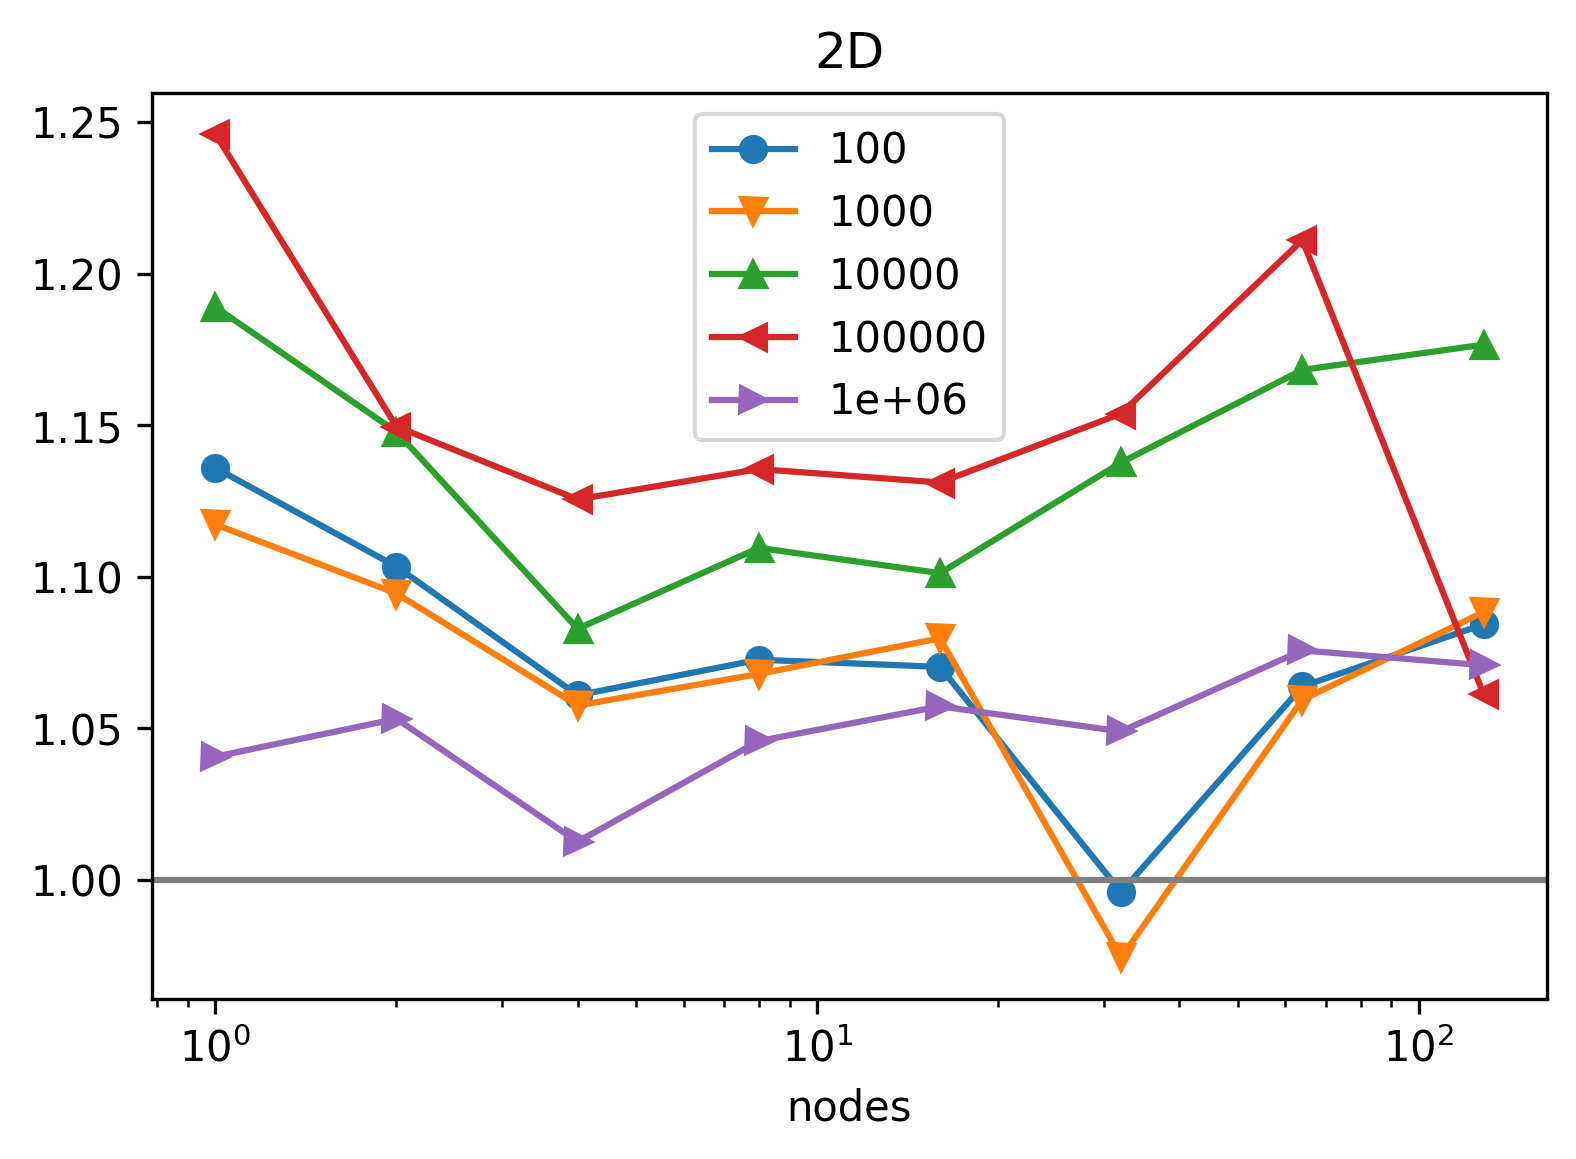

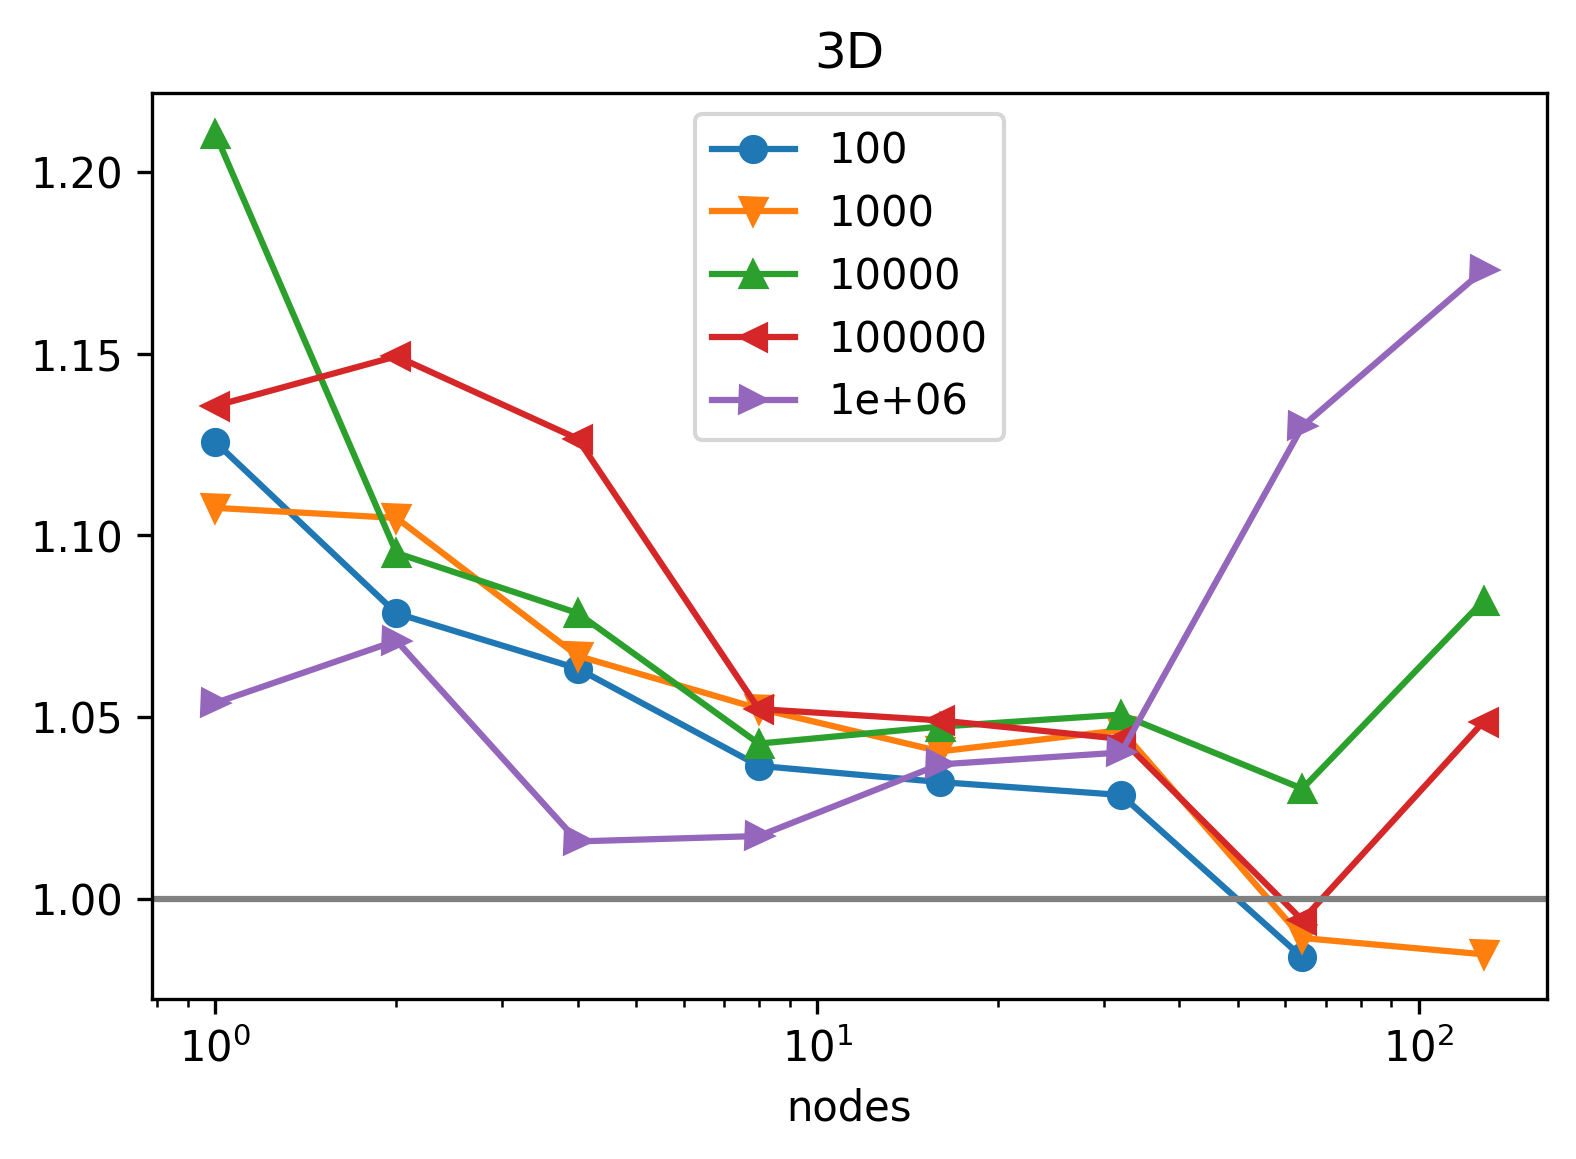

In [21]:
df = df_stencil / df_neighborhood
for dim in df_stencil.columns.levels[0]:
    fig, ax = plt.subplots(dpi=300)
    _df = df[dim]
    ax.set_prop_cycle(default_cycler)
    ax.set_title(f"{dim}D")
    _df.plot(ax=ax, legend=False, logx=True, logy=False)
    ax.legend([f"{n:g}" for n in df.columns.levels[1]])
    ax.axhline(1, color="gray")
    fig.savefig(f"speedup-neighborhood-{dim}d.png")